# Download Historical Data Aave

In [1]:
#Libraries
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from pandas.io.json import json_normalize
import pickle
import os 
import sys
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

In [2]:
pathAPI = os.getcwd()
pathData = os.path.join(pathAPI,'graphData')

In [3]:
#Define API
sample_transport=RequestsHTTPTransport(
   url='https://api.thegraph.com/subgraphs/name/aave/protocol-v2',
   verify=True,
   retries=5,
)
client = Client(
   transport=sample_transport
)

In [4]:
#Assets
WETH='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc20xb53c1a33016b2dc2ff3653530bff1848a515c8c5'
WBTC='0x2260fac5e5542a773aa44fbcfedf7c193bc2c5990xb53c1a33016b2dc2ff3653530bff1848a515c8c5'
DAI='0x6b175474e89094c44da98b954eedeac495271d0f0xb53c1a33016b2dc2ff3653530bff1848a515c8c5'
USDC='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb480xb53c1a33016b2dc2ff3653530bff1848a515c8c5'
USDT='0xdac17f958d2ee523a2206206994597c13d831ec70xb53c1a33016b2dc2ff3653530bff1848a515c8c5'

In [5]:
#query USDT
queryM = gql('''
query {
  reserve (id: "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc20xb53c1a33016b2dc2ff3653530bff1848a515c8c5") { 
    id
    paramsHistory(first: 1000) {
      id
      lifetimeFlashLoanPremium
      lifetimeDepositorsInterestEarned
      lifetimeReserveFactorAccrued
      totalATokenSupply
      totalPrincipalStableDebt
      totalCurrentVariableDebt
      utilizationRate
      variableBorrowRate
      stableBorrowRate
      liquidityRate
      priceInUsd
      timestamp
    }
  }
}
''')

In [6]:
dataM = client.execute(queryM)

In [7]:
tblM=pd.json_normalize(dataM['reserve']['paramsHistory'])

In [8]:
tblM.head()

,id,lifetimeDepositorsInterestEarned,lifetimeFlashLoanPremium,lifetimeReserveFactorAccrued,liquidityRate,priceInUsd,stableBorrowRate,timestamp,totalATokenSupply,totalCurrentVariableDebt,totalPrincipalStableDebt,utilizationRate,variableBorrowRate
0,0x00002b10f2d75fa350309b3bc4178a01bdee3f065ff0...,405476969651544509790,1263501751809831950912,45082338772694628016,65905542899792816422411,3406.316027380001795144862001768891,33237181335705479045463470,1633275840,2023196576240454603016789,41628779626943818285290,956828834234220118769,0.02023357,2589745068564383236370775
1,0x0000749eddd2bbff28a9ab3f6c78122880e1ab8aca0c...,338348876832886563888,1205221500688728120423,37618327265788233259,223278901171683082991478,2391.118083180004491660642560699955,36688173729686230231359209,1627601050,1776485959734460896512033,76576094609962036269193,651800944610087262963,0.042635,5350538983748984185087368
2,0x000094bffc67d66b34ef8853693846a532b91c787380...,358482290065244714614,1230121671297688862666,39856815654481118770,256970193012495894583964,3256.658198990007823019577367489561,37159295335905897411347821,1628959994,1858533886504509751788253,85574171127921986106161,911794671004383209663,0.04571288,5727436268724717929078257
3,0x00022fc9b77b74dad17ac21cf4bbfd00d9f235da4de6...,333206938954635235009,1201435899117830762280,37046632257839944796,214587377041282181182459,2146.920636970002936382015728428015,36559254875651412886583013,1627178698,1777699467738234949177105,75184719488501282928921,606288026157887538210,0.041802,5247403900521130309266411
4,0x0002f3bb4979ea1647912d45b9d2d00344783a15e136...,272009441399363196333,1166701529445431234634,30242565330058214426,1446165002064832107238194,2253.107581180003646055419156520747,47452933472757910973055518,1624224687,1142269030444963199652934,128807213283349153821361,772875103318247624711,0.11231928,13962346778206328778444414


In [8]:
#Save Data
f = open(os.path.join(pathData,'eth_history_aave.pickle'), 'wb')
pickle.dump(tblM, f,-1)          
f.close() 

# Serie para Margenes de Intermediacion

In [9]:
#Units
wei=1.0e+18 #$ETH
rey=1.0e+27 #tasas 
btc=1.0e+5 #$ btc
stable=1.0e+6 #$ stable

In [3]:
#Load Downloaded Data
f = open(os.path.join(pathData,'eth_history_aave.pickle'), 'rb')
tblM = pickle.load(f)     
f.close() 

In [10]:
tblM['Date']=pd.to_datetime(tblM['timestamp'], unit='s')

In [11]:
#Aggregates
priceUSD=tblM['priceInUsd'].astype(float)
tsupply=tblM['totalATokenSupply'].astype(float)/wei
tdebtCv=tblM['totalCurrentVariableDebt'].astype(float)/wei
tdebtPs=tblM['totalPrincipalStableDebt'].astype(float)/wei
tborrow=tdebtCv+tdebtPs
Opmargin=tblM['lifetimeReserveFactorAccrued'].astype(float)/wei
intExpense=tblM['lifetimeDepositorsInterestEarned'].astype(float)/wei
intIncomeF=tblM['lifetimeFlashLoanPremium'].astype(float)/wei
intIncomeV=Opmargin+intExpense
cMkt_agg=pd.DataFrame(data={'tsupply':tsupply,
                            'tborrowV':tdebtCv,'tborrowS':tdebtPs,'tborrow':tborrow,
                            'intIncome':intIncomeV,'intIncomeFlash':intIncomeF,'intExpense':intExpense,'opMargin':Opmargin,
                           'priceUSD':priceUSD})
cMkt_agg=cMkt_agg.set_index(tblM['Date'])
cMkt_agg=cMkt_agg.sort_index(axis=0)

In [12]:
cMkt_agg.tail()

,tsupply,tborrowV,tborrowS,tborrow,intIncome,intIncomeFlash,intExpense,opMargin,priceUSD
Date,,,,,,,,,
2021-10-29 11:20:43,2.083753e+06,36383.585565,440.711445,36824.297010,458.031422,1740.523082,412.200419,45.831003,4323.452897
2021-10-29 16:25:18,1.569014e+06,36191.342961,440.711445,36632.054406,458.098813,1740.523082,412.261067,45.837746,4439.001418
2021-10-29 20:07:07,1.441649e+06,36097.873875,440.711445,36538.585320,458.151966,1740.641267,412.308902,45.843064,4390.560000
2021-10-30 23:40:57,1.194606e+06,35608.320434,440.711445,36049.031879,458.560059,1740.683573,412.676162,45.883897,4311.311097
2021-10-31 01:32:49,1.219754e+06,35708.345549,440.711445,36149.056994,458.594174,1740.683573,412.706863,45.887310,4382.599091


In [13]:
#Resample Daily data
daily_agg=cMkt_agg.resample('D').mean().interpolate()

In [14]:
daily_agg.tail()

,tsupply,tborrowV,tborrowS,tborrow,intIncome,intIncomeFlash,intExpense,opMargin,priceUSD
Date,,,,,,,,,
2021-07-21,1.769079e+06,76094.105357,590.498492,76684.603849,366.023220,1199.602593,329.399868,36.623351,1883.552763
2021-07-22,1.775665e+06,71821.489573,598.169365,72419.658937,367.110548,1200.607144,330.378401,36.732147,2000.886714
2021-07-23,1.782713e+06,76294.002275,603.643320,76897.645595,368.702150,1201.021111,331.810750,36.891400,2017.994787
2021-07-24,1.782053e+06,76348.758308,604.172261,76952.930569,369.427645,1201.275712,332.463653,36.963992,2133.925621
2021-07-25,1.769539e+06,75137.384445,606.252010,75743.636455,370.619143,1201.479925,333.535932,37.083211,2145.190902


In [15]:
ts_usd=daily_agg.tsupply*daily_agg.priceUSD/1e6
tb_usd=daily_agg.tborrow*daily_agg.priceUSD/1e6

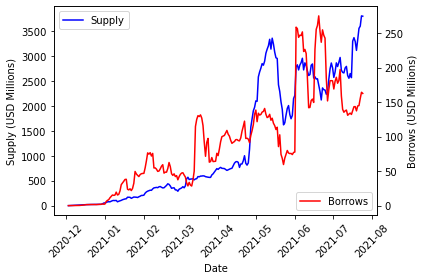

In [16]:
fig,ax1=plt.subplots()

# ax1.set_title("DAI Supply and Borrows")
ax1.set_xlabel('Date')
ax1.set_ylabel("Supply (USD Millions)")
ax1.plot(ts_usd.index,ts_usd,color="b",label="Supply")
ax1.legend(loc="best")
ax2 = ax1.twinx()  

ax2.set_ylabel('Borrows (USD Millions)')  
ax2.plot(tb_usd.index,tb_usd,color="r",label="Borrows")
ax2.legend(loc='lower right')
ax1.tick_params(axis='x', rotation=45)

fig.tight_layout() 
fig.savefig('eth_supply_borrows.png')  
plt.show()

In [28]:
ts_usd.tail()

Date
2021-07-21    3332.153117
2021-07-22    3552.903517
2021-07-23    3597.504643
2021-07-24    3802.768046
2021-07-25    3795.999902
Freq: D, dtype: float64

In [17]:
brate=tblM['variableBorrowRate'].astype(float)/rey
sbrate=tblM['stableBorrowRate'].astype(float)/rey
srate=tblM['liquidityRate'].astype(float)/rey
utilization=tblM['utilizationRate'].astype(float)
mkt_rts=pd.DataFrame(data={'var_borrow':brate,'sta_borrow':sbrate,
                            'sup.r':srate,'utilization':utilization})
mkt_rts=mkt_rts.set_index(tblM['Date'])
mkt_rts=mkt_rts.sort_index(axis=0)

In [18]:
daily_rates=mkt_rts.resample('D').mean().interpolate()

In [19]:
daily_rates

,var_borrow,sta_borrow,sup.r,utilization
Date,,,,
2020-12-03,0.002219,0.032774,0.000036,0.018028
2020-12-04,0.002221,0.032776,0.000043,0.018284
2020-12-05,0.002223,0.032779,0.000051,0.018540
2020-12-06,0.004038,0.035047,0.000151,0.032805
2020-12-07,0.003896,0.034871,0.000180,0.031655
...,...,...,...,...
2021-07-21,0.005335,0.036669,0.000221,0.042515
2021-07-22,0.005020,0.036275,0.000197,0.039951
2021-07-23,0.005309,0.036636,0.000219,0.042307


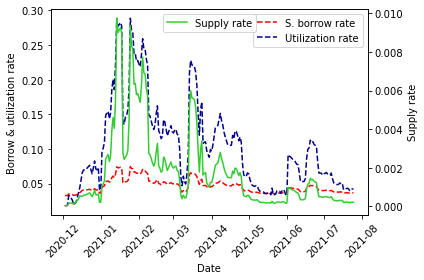

In [20]:
fig,ax1=plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel("Borrow & utilization rate")
# ax1.plot(daily_rates.index,daily_rates["var_borrow"],color="b",label="V. borrow rate",ls=":")
ax1.plot(daily_rates.index,daily_rates["sta_borrow"], color="r",label="S. borrow rate",ls="--")
ax1.plot(daily_rates.index,daily_rates["utilization"], color="darkblue",label="Utilization rate",ls="--")
ax1.legend(loc="best")
ax2 = ax1.twinx()  

ax2.set_ylabel('Supply rate')  
ax2.plot(daily_rates.index,daily_rates["sup.r"],color="limegreen",label="Supply rate")
ax2.legend(loc='upper center')
ax1.tick_params(axis='x', rotation=45)

fig.tight_layout() 
fig.savefig('eth_rates.png') 
plt.show()

In [26]:
daily_rates['var_borrow'].tail()

Date
2021-07-21    0.005335
2021-07-22    0.005020
2021-07-23    0.005309
2021-07-24    0.005315
2021-07-25    0.005268
Freq: D, Name: var_borrow, dtype: float64

In [ ]:
plt.plot(daily_rts.index, daily_rts.utilization)
plt.xlabel('Time')
plt.ylabel('Utilization')
plt.show()

In [ ]:
plt.plot(BR)
plt.xlabel('Time')
plt.ylabel('Borrow Rate')
plt.show()

In [ ]:
plt.plot(SR)
plt.xlabel('Time')
plt.ylabel('Supply Rate')
plt.show()

In [ ]:
Uta[Uta.index<'2020-07-15'].describe()

In [ ]:
Uta[Uta.index>'2020-07-15'].describe()

In [ ]:
plt.plot(Uta[Uta.index>'2020-07-15'])
plt.xlabel('Time')
plt.ylabel('Utilization')
plt.show()

In [ ]:
plt.plot(TB)
plt.xlabel('Time')
plt.ylabel('Total Borrow in Wei')
plt.show()

In [ ]:
plt.plot(TS)
plt.xlabel('Time')
plt.ylabel('Total Supply in Wei')
plt.show()

In [ ]:
TS.head()

In [ ]:
plt.plot(1/Xrate)
plt.xlabel('Time')
plt.ylabel('Exchange rate: 1ETH to #cETH')
plt.show()

In [ ]:
plt.plot(PUSD)
plt.xlabel('Time')
plt.ylabel('Price of ETH in USD')
plt.show()

In [ ]:
PUSD[PUSD.index>'2020-03-15'].head()